# Custom Datasets

### Importing Images

In [1]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


## Exploratory Data Analysis

### Directory Structure

In [16]:
from pathlib import Path

def walk_directory(directory:str | Path):
    # Create a Path object for the specified directory
    directory_path = Path(directory)
    n_file = 0
    # Iterate over the contents of the directory
    for entry in directory_path.iterdir():
        # Check if the entry is a directory
        if entry.is_dir():
            # You can recursively call the walk_directory function to explore subdirectories
            walk_directory(entry)
        else:
            n_file += 1 
    if n_file != 0:
        print(f"The {directory_path} directory has {n_file} files")

In [17]:
walk_directory("data")

The data/FashionMNIST/raw directory has 8 files
The data/pizza_steak_sushi/train/pizza directory has 78 files
The data/pizza_steak_sushi/train/steak directory has 75 files
The data/pizza_steak_sushi/train/sushi directory has 72 files
The data/pizza_steak_sushi/test/pizza directory has 25 files
The data/pizza_steak_sushi/test/steak directory has 19 files
The data/pizza_steak_sushi/test/sushi directory has 31 files
The data directory has 3 files


In [18]:
# Setup train and testing paths
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Creating a Custom Dataset

In [19]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [22]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [51]:
# Write transform for image
data_transform_2 = transforms.Compose([
    transforms.Lambda(
        lambda 
            image: (
                [transforms.Resize(size=(64, 64))(image)] 
                + 
                [trans_image for trans_image in transforms.FiveCrop(size=(64, 64))(image)]
                +
                [transforms.Resize(size=(64, 64))(
                    transforms.RandomRotation(degrees=(0, 180))(image)
                ) for _ in range(4)]
            )     
    ),
    # Turn the image into a torch.Tensor
    # this also converts all pixel values from [0, 255] to [0.0, 1.0] 
    transforms.Lambda(
        lambda 
            lista:torch.stack([transforms.ToTensor()(image) for image in lista])
    )
])

In [52]:
import random
from PIL import Image
import matplotlib.pyplot as plt

def plot_transformed_images(image_path: str | Path, transform, 
                            file_extension:str = "jpg", n=3, seed=42):
    """Plots a series of random images from image_path.

    Args:
        image_path: path, where image files are located. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    directory_path = Path(image_path)
    possible_images = [
        entry for entry in directory_path.iterdir() 
        if entry.is_file() and file_extension in str(entry)
    ]
    if possible_images !=[]:
        random_image_paths = random.sample(possible_images, k=n)
        for image in random_image_paths:
            with Image.open(image) as f:
                fig, ax = plt.subplots(1, 2)
                ax[0].imshow(f) 
                ax[0].set_title(f"Original \nSize: {f.size}")
                ax[0].axis("off")
                # Transform and plot image
                # Note: permute() will change shape of image to suit matplotlib 
                # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
                transformed_images = [trans_image.permute(1, 2, 0) 
                                      for trans_image in  transform(f)]
                for trans_image in transformed_images:
                    ax[1].imshow(trans_image) 
                    ax[1].set_title(f"Transformed \nSize: {trans_image.shape}")
                    ax[1].axis("off")
                    fig.suptitle(f"Class: {image.parent.stem}", fontsize=16)
    else:
        raise Exception(
            f"The directory {image_path} has no images with extension {file_extension}"
        )

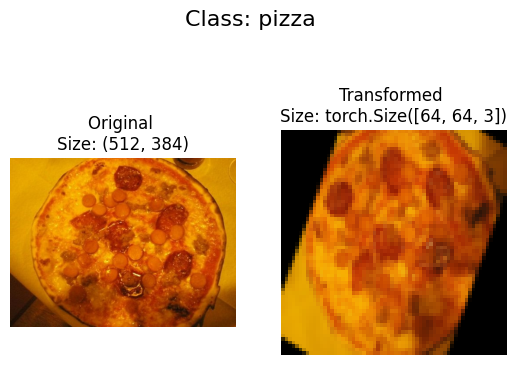

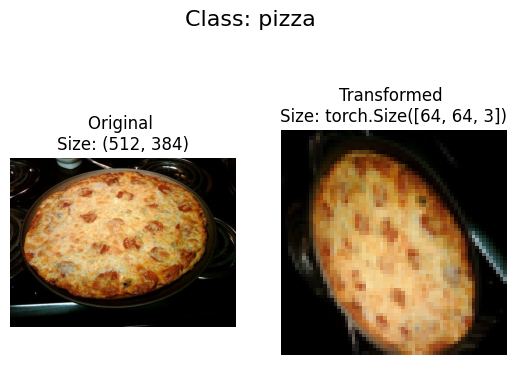

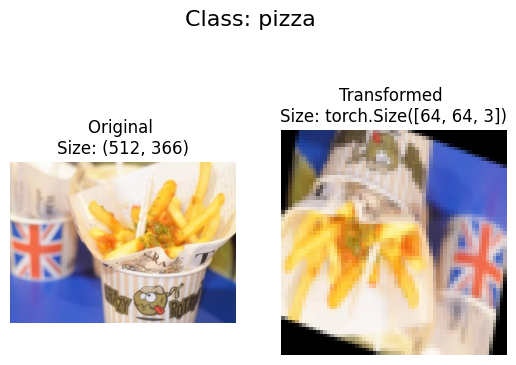

In [53]:
plot_transformed_images(image_path/"train"/"pizza", 
                        transform=data_transform_2, 
                        n=3)

In [27]:
image_path

PosixPath('data/pizza_steak_sushi')